# Philly Bail Fund
## Analysis of factors related to Bail Amounts

For more details, see the github repo: https://github.com/CodeForPhilly/pbf-analysis

[insert overview of approach here.. img?]

*__IMPORTANT__*: There are several factors that we can't control for, because the data is not available. This means that drawing conclusions from any correlations should not be assumed to be causal. Use with caution!
Mainly,
* Criminal history
* Magistrate that sets the bail
* 


__ITEMS FOR FOLLOW UP__

[ ] Is there a set of legal criteria or guidance for setting bail

[X] Is filing date really the time/day that bail is set?  - YES (7/16 - @alinder)

### Imports

In [1]:
# PEP8 fans please close your eyes
import pandas as pd, numpy as np, os, re, json, pickle, math, calendar, joblib
from time import time
from pprint import pprint
from pathlib import Path
from datetime import datetime

#charting
import seaborn as sns
import matplotlib.pyplot as plt

### Display options for notebooks
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 25)

### set path directories
curr_dir = Path(os.getcwd())
#print('Current Directory is: ', str(curr_dir))
data_dir = Path(curr_dir.parents[0] / 'Data/')
artifacts_dir = Path(curr_dir / 'artifacts/')

In [2]:
### Common project specific variables
FILENAME = '0c_distinct_dockets.csv'  # original data
TARGET_VARIABLE_NAME = 'bail_amount'
HOLDOUT_INDICATOR_NAME = 'holdout_ind'
DATECOL = 'filing_date'

### Helper Functions

In [3]:
# helper function to reduce memory footprint of the dataframe
def reduce_mem_usage(df, verbose=True):
    import numpy as np
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### Data Import

In [45]:
# read in the data and take a peek at it
indata = reduce_mem_usage(pd.read_csv(Path(data_dir) / FILENAME, parse_dates=['filing_date'], index_col='id'))

indata.head(3)

Mem. usage decreased to  0.40 MB (15.9% reduction)


,age,address,docket_number,filing_date,charge,represented_by,bail_type,bail_status,bail_amount,outstanding_bail_amount
id,,,,,,,,,,
3909,27.0,"Philadelphia, PA 19141",MC-51-CR-0011746-2020,2020-06-16 00:37:00+00:00,DUI: Gen Imp/Inc of Driving Safely - 1st Off,Defender Association of Philadelphia,Posted,ROR,0,0
4538,44.0,"Philadelphia, PA 19124",MC-51-CR-0011747-2020,2020-06-16 00:41:00+00:00,Verify Address or Photographed as Required,Defender Association of Philadelphia,Set,Monetary,50000,0
120,24.0,"Philadelphia, PA 19142",MC-51-CR-0011743-2020,2020-06-16 00:52:00+00:00,Criminal Mischief,Defender Association of Philadelphia,Posted,ROR,0,0


### Data Setup

After importing the data, our first step is to remove anything that may be unecessary for analysis. However, we can extract some useful information from the date field before dropping it. And lastly, we have data for situations for which there is no bail - so we are going to remove those rows with 0 bail from this point forward.

It may be worth an exercise to predict Bail Yes/no and do another analysis. However this notebook is starting off as limited to the bail amount that is being set.

__Steps__ 

__A1.__ Keep = bail_amount, charge, bail_status, filing_date, age, represented_by

__A2.__ Create hour of day and day of week from filing_date, then drop originial filing_date

__A3.__ Delete rows where bail_status = 'Denied' (we will only worry about ones where there is a set amount)

##### A1: Keep only columns that might impact the bail amount

In [46]:
# drop things we know aren't useful
drop_list = ['address','docket_number','bail_type','outstanding_bail_amount']

indata.drop(columns=drop_list, inplace=True, errors='ignore')

##### A2: Parse Hour of Day and Day of Week, before dropping the date field

In [47]:
# hour of day
indata['filed_hour_of_day'] = indata[DATECOL].dt.hour

# day of the week with Monday=0, Sunday=6
indata['filed_day_of_week'] = indata[DATECOL].dt.dayofweek.apply(lambda x: calendar.day_abbr[x])

indata.drop(columns=[DATECOL], inplace=True, errors='ignore')

indata['charge'] = indata['charge'].str.lower().str.replace('[^\w\s]','')

##### A3: Remove rows where bail does not apply

In [48]:
# remove rows where bail amount is more than zero
clean = indata[indata['bail_amount']>0]

clean.head(5)

,age,charge,represented_by,bail_status,bail_amount,filed_hour_of_day,filed_day_of_week
id,,,,,,,
4538,44.0,verify address or photographed as required,Defender Association of Philadelphia,Monetary,50000,0,Tue
291,32.0,contempt for violation of order or agreement,Defender Association of Philadelphia,Monetary,50000,1,Tue
291,32.0,burglary overnight accommodations person pres...,Defender Association of Philadelphia,Monetary,75000,1,Tue
291,32.0,burglary overnight accommodations person pres...,Defender Association of Philadelphia,Monetary,75000,1,Tue
2396,51.0,simple assault,Defender Association of Philadelphia,Unsecured,25000,1,Tue


### Load Models Objects

In order to analyze effects of each item on `bail_amount`, we'll need to build a model that predicts it. This was all done in [another notebook]. Here, we'll simply import these models and then we can start our analysis on the various effects. These were trained using a Random Forest regressor with an ElasticNet submodel built from words in the charges column. See [other notebook] for details.

In [49]:
submodel = joblib.load(Path(artifacts_dir) / 'text_submodel.mdl')
mainmodel = joblib.load(Path(artifacts_dir) / 'model.mdl')
cols = list(joblib.load(Path(artifacts_dir) / 'model_col_order.list'))
cols_preprocessor = list(joblib.load(Path(artifacts_dir) / 'preprocessor_col_order.list'))
cols_preprocessor.remove(TARGET_VARIABLE_NAME)

NOTE: I am having problems doing this permutation importance elegantly,.... and some of it has to do w/ a column ordering.

I posted this question on stack overflow awaiting an answer: https://stackoverflow.com/questions/63020955/confused-about-column-order-for-sklearn-pipeline-imputer

In [50]:
# use submodel to add replace the charge field with a number
x = clean[cols].copy()
y = clean[TARGET_VARIABLE_NAME].copy()

x['charge'] = submodel.predict(x[['charge']])

x
# break out estimator and imputer because thats how eli5 needs it
#estimator = mainmodel.named_steps['final_model']
#imputer = mainmodel.named_steps['preprocessor']

#x_transformed = imputer.transform(x[cols])

#x_transformed_col_order = ['age','represented_by','bail_status','filed_hour_of_day','filed_day_of_week','charge']

#df_x_transformed = pd.DataFrame(x_transformed, columns=cols)
#scored = pd.DataFrame(estimator.predict(x_transformed), columns=x_transformed_col_order)

,age,charge,represented_by,bail_status,filed_hour_of_day,filed_day_of_week
id,,,,,,
4538,44.0,85129.505695,Defender Association of Philadelphia,Monetary,0,Tue
291,32.0,26127.480819,Defender Association of Philadelphia,Monetary,1,Tue
291,32.0,39807.765545,Defender Association of Philadelphia,Monetary,1,Tue
291,32.0,39807.765545,Defender Association of Philadelphia,Monetary,1,Tue
2396,51.0,21465.051448,Defender Association of Philadelphia,Unsecured,1,Tue
...,...,...,...,...,...,...
3776,34.0,104775.836062,Defender Association of Philadelphia,Monetary,19,Sat
3466,23.0,85183.001412,Defender Association of Philadelphia,Monetary,21,Sat
649,22.0,85183.001412,Defender Association of Philadelphia,Monetary,21,Sat


## Analysis

E1. Matrix of correlation (mutual information?) to prove these are independent variables

E2. Permutation Importance to show the relative importance of each variable in the model (this is a better interpretation than the tree-importance that comes from the model itself)

E3. Partial Dependence Plots for each of the variables (except the text)

E4. Score original training dataset with model. Filter for observations where predicted value is either top 10% or bottom 10%. Run SHAP to extract #1 reason for each observation in the top/bottom 10%.

E5. Look for any cases where age, represented_by is the #1 factor for the bail_amount. These could be interesting cases to highlight

E6. Word cloud of the terms - this could take some work I'm not too familiar w/ this


### E1: Correlation Matrix 
Can we use Mutual Information ?

In [51]:
# I did check this in external tools and prove that they are independent - I just need to find time to code this in python and make a nice graphic

### E2: Feature Impact

In [52]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot

In [53]:
pimp = permutation_importance(mainmodel, x, y, scoring='neg_mean_squared_error')

In [54]:
importances = pimp.importances_mean
indices = np.argsort(importances)
feature_names = x.columns

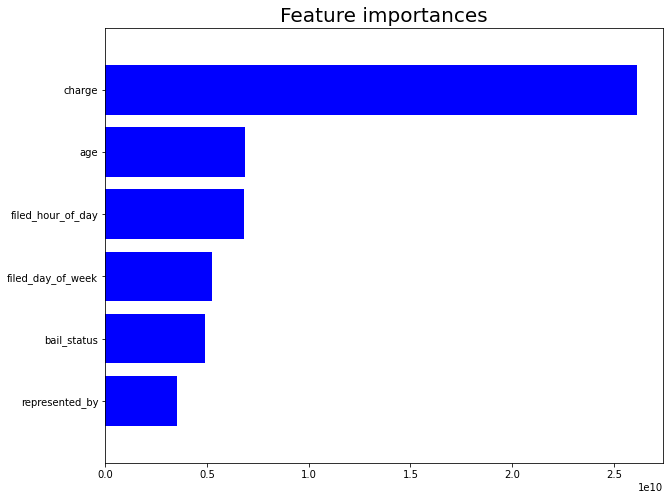

In [55]:
# Plot 
plt.figure(figsize=(10,8))
plt.title("Feature importances", fontsize=20)
plt.barh(range(x.shape[1]), importances[indices], color="blue", align="center")
plt.yticks(range(x.shape[1]), [feature_names[i] for i in indices])
plt.ylim([-1, x.shape[1]])
plt.show()

The above chart seems to indicate that while the `charge` is the most important variable towards predicting `bail_amt`, we see that the **hour of day** matters as well. Could this be because of some hidden human bias? Or perhaps due to a systematic way that cases are processed from within the courts over the course of the day. 

Let's dig in deeper and see _how_ time of day matters.

### E3: Feature Effects
Partial Dependence Plots

In [56]:
from pycebox.ice import ice, ice_plot

# pcyebox requires us to break up our model into the pre-processing and the estimator
# this is super annoying but I could not find any other way around it
estimator = mainmodel.named_steps['final_model']
imputer = mainmodel.named_steps['preprocessor']

# now lets make a dataframe that applies the preprocessing to the data first
x_preprocessed = imputer.transform(x[cols])

# pcyebox also wants a dataframe instead of a matrix
df_x_preprocessed = pd.DataFrame(x_preprocessed, columns=cols_preprocessor)

In [57]:
ice_filed_hour_of_day = ice(data=df_x_preprocessed.sample(n=750), column='filed_hour_of_day', predict=estimator.predict)
ice_age = ice(data=df_x_preprocessed[df_x_preprocessed['age'].between(0,70)].sample(n=750), column='age', predict=estimator.predict)

#### Hour of Day

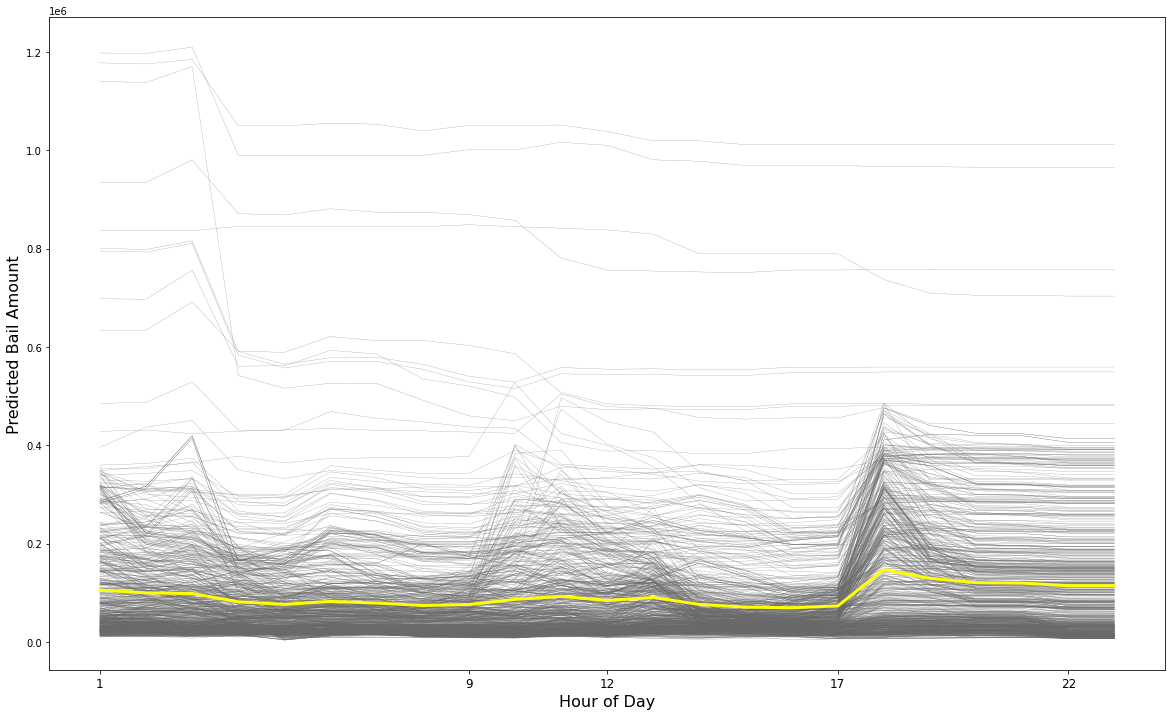

In [58]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 12

ice_plot(ice_filed_hour_of_day, c='dimgray', linewidth=0.2, plot_pdp=True, pdp_kwargs={'c': 'yellow', 'linewidth': 3})
plt.ylabel('Predicted Bail Amount', fontsize=16)
plt.xticks([1, 9, 12, 17, 22], fontsize=12)
plt.xlabel('Hour of Day', fontsize=16);

Interestingly, we can see that predicted bail amount seems to go up right before lunch, and then after 5pm.

Would be interesting to view this chart for every day of the week.

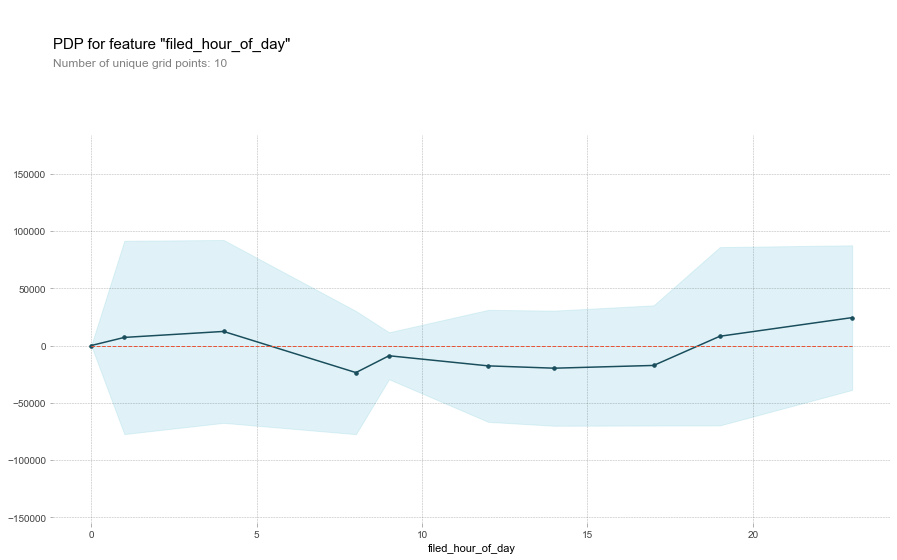

In [59]:
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=mainmodel, dataset=x,
                            model_features=x.columns.tolist(), feature='filed_hour_of_day')

# plot it
pdp.pdp_plot(pdp_goals, 'filed_hour_of_day')
plt.show()

#### Age

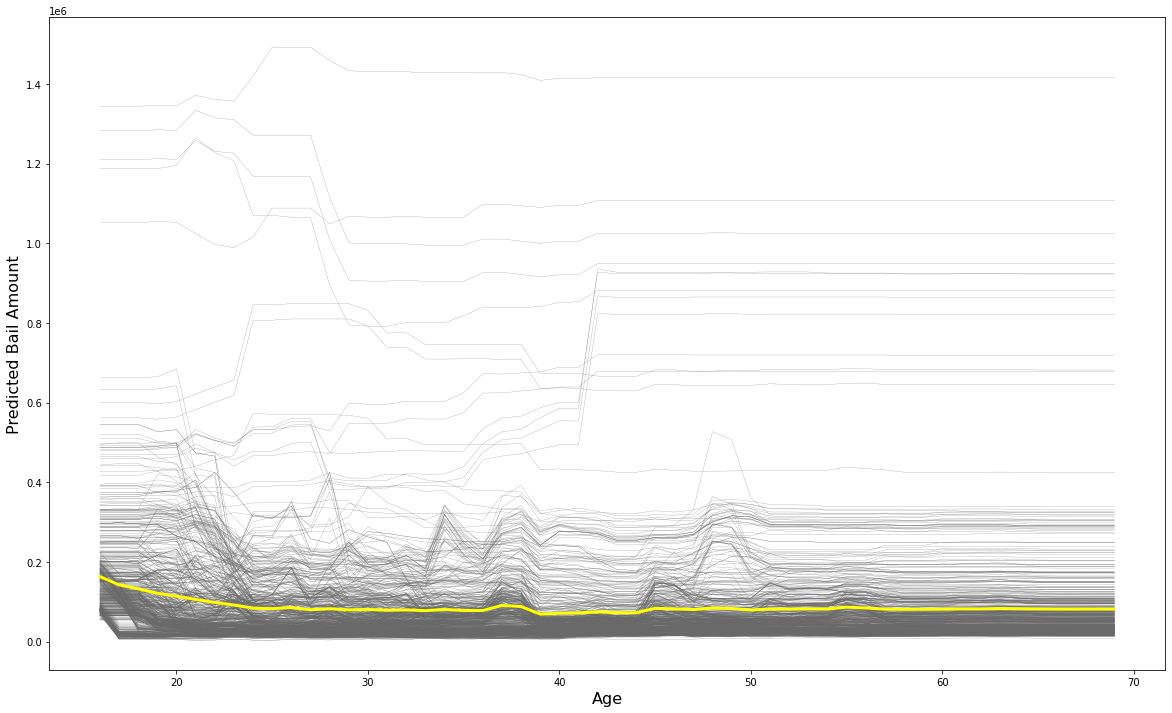

In [60]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 12

ice_plot(ice_age, c='dimgray', linewidth=0.2, plot_pdp=True, pdp_kwargs={'c': 'yellow', 'linewidth': 3})
plt.ylabel('Predicted Bail Amount', fontsize=16)
plt.xlabel('Age', fontsize=16);

Here we can see a slight bias towards higher bail for younger ages. Keep in mind that criminial history is not something that we're normalizing for - and the combination of young and a criminal history could be an acceptable reason for higher bail. 

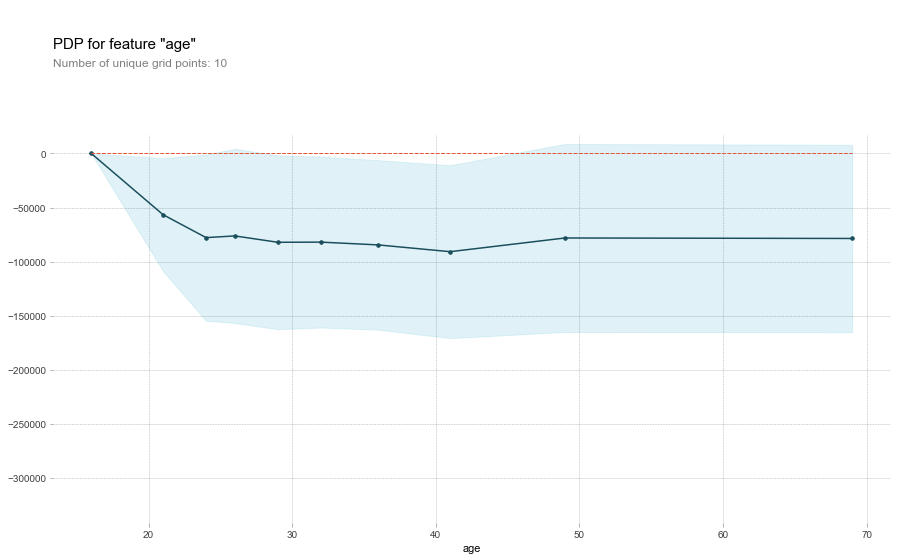

In [61]:
from pdpbox import pdp, get_dataset, info_plots

filteredx = x[x['age'].between(15,70)]
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=mainmodel, dataset=filteredx,
                            model_features=x.columns.tolist(), feature='age')

# plot it
pdp.pdp_plot(pdp_goals, 'age')
plt.show()

--------------------------------
#### Everything idea below this line has nice exmaples on this website: http://savvastjortjoglou.com/intrepretable-machine-learning-nfl-combine.html
#### Also this: http://restanalytics.com/2019-05-18-Machine-Learning-Interpretability/
--------------------------------

##### E4: Prediction Explanations
Row level reasoning behind predictions (SHAP)


In [62]:
import shap

# create our SHAP explainer
shap_explainer = shap.TreeExplainer(estimator)
# calculate the shapley values for our test set
test_shap_vals = shap_explainer.shap_values(x_preprocessed)

In [63]:
shap.initjs()

In [70]:
# plot the explanation for a single prediction
shap.force_plot(df_x_preprocessed.iloc[0, :], test_shap_vals[0, :])

TypeError: Object of type Series is not JSON serializable

In [ ]:
shap.force_plot(test_shap_vals, x)

##### E5: Highlight interesting cases for deep dive

Any where represented_by is #1 reason?

Any where age is #1 reason?

##### E6: Word Cloud on terms

Possible to do independent relationship among words and target? Not sure if this is easy and worth doing